# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session

We're using TF 1.13.1


Using TensorFlow backend.


# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email

In [2]:
grader = grading.Grader(assignment_key="XtD7ho3TEeiHQBLWejjYAA", 
                        all_parts=["9XaAS", "vmogZ", "RMv95", "i8bgs", "rE763"])

In [3]:
# token expires every 30 min
COURSERA_TOKEN = "Roe8wXhO7Mo0H5zM"
COURSERA_EMAIL = "me@jessequinn.info"

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [4]:
import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


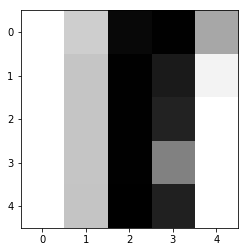

And the whole sample:


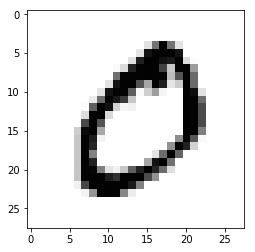

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [5]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Your task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

You will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [6]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [7]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [8]:
# run this again if you remake your graph
s = reset_tf_session()

In [9]:
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

In [10]:
# Model parameters: W and b
### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
W = tf.get_variable("W", shape=(n_input,10), dtype=tf.float32)
### YOUR CODE HERE ### tf.get_variable(...)
b = tf.get_variable("b", shape=(10), dtype=tf.float32)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# Placeholders for the input data
### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_X = tf.placeholder(tf.float32, shape=(None, n_input))
### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels
input_y = tf.placeholder(tf.float32, shape=(None, n_classes))

In [12]:
# Compute predictions
logits = input_X@W + b
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)
# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=input_y))
step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
# step = tf.train.AdagradOptimizer(learning_rate=0.001).minimize(loss)
# step = tf.train.AdadeltaOptimizer(learning_rate=0.001).minimize(loss)

In [13]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3Xl8zNf%2Bx/HXZJdNFgmyWGMJmiCJpQjai4otRS2tnbpVLl1U3bpaSn91W62WttQWrVrrVqklVSroSmgR4SZxLYklkpDInkzm/P74NkMqSROyGD7Px%2BP7mOW7fWbCTN4553uOTimlEEIIIYQQQghR6cyquwAhhBBCCCGEeFhIABNCCCGEEEKIKiIBTAghhBBCCCGqiAQwIYQQQgghhKgiEsCEEEIIIYQQoopIABNCCCGEEEKIKiIBTAghhBBCCCGqiAQwIYQQQgghhKgiEsCEEEIIIYQQoopIABNCCCGEEEKIKiIBTAghhBBCCCGqiAQwIYQQQgghhKgiEsCEEEIIIYQQoopIABNCCCGEEEKIKiIBTAghhBBCCCGqiAQwIYQQQgghhKgiEsCEEEIIIYQQoopIABNCCCGEEEKIKiIBTAghhBBCCCGqiAQwIUS56XQ64uLiqrsMIYQQQgiTIwFMiPuMXq%2Bv7hLu2YPwGoQQwhQppTAYDNVdhhCiFBLAhKhC8fHxDBw4EDc3N1xdXZkyZQpr1qyhU6dOvPjii7i6ujJnzhwMBgPz58%2Bnfv36uLu7M2rUKNLS0gDIyclhxIgRuLq64uTkRFBQEImJiQCsWbOGRo0a4eDgQMOGDVm3bl2JtZw5c4YePXrg4uJCs2bN2Lx5s3HdmDFjmDx5Mn369MHBwYH27dtz9uxZAIKDgwHw9/fH3t6eTZs2ERERgZeXF//%2B97%2BpU6cOY8eOBWDFihX4%2BPjg4uJC//79uXz5svEcOp2OxYsX06hRI2rVqsUrr7yCwWAgLy8PFxcXTp48adz22rVr2NrakpSUVEE/CSGEqFwLFiygcePGODg40KJFC7Zu3Wpct2LFCnx9fY3rjh07BhT/HQEwZ84cRowYYdz//Pnz6HQ64x%2B7unXrxqxZs%2BjUqRO2trb873//IywszHiORo0a8emnnxapb9u2bbRu3RpHR0caN25MeHg4X375JQEBAUW2e//99xkwYEClvEdCPLSUEKJK6PV65efnp1544QWVkZGhsrOz1aFDh1RYWJgyNzdXixcvVvn5%2BSorK0utWrVKNW7cWJ09e1alp6erJ598Uo0YMUIppdSyZctU3759VWZmptLr9SoyMlKlpaWpjIwM5eDgoM6cOaOUUury5csqKiqq2FoyMjKUl5eXWr16tcrPz1fHjh1Trq6u6tSpU0oppUaPHq1cXFzUr7/%2BqvLz89XTTz%2Bthg4datwfULGxscbH%2B/fvV%2Bbm5mrGjBkqJydHZWVlqX379ilXV1d19OhRlZOTo6ZMmaK6dOlS5BjdunVTKSkp6sKFC6pJkyZqxYoVSimlJk2apGbMmGHc9oMPPlB9%2B/atoJ%2BEEEJUvs2bN6tLly6pgoICtXHjRmVra6suX76sNm/erDw8PNThw4eVwWBQsbGx6vz58yV%2BRyil1BtvvKGeeeYZ47HPnTunAJWfn6%2BUUqpr167K29tbRUVFqfz8fJWXl6d27Nih4uLilMFgUBEREapGjRrq6NGjSimlfv31V%2BXo6Kj27NmjCgoKVEJCgjp9%2BrTKyclRzs7OKjo62niu1q1bqy1btlThOyfEg08CmBBV5KefflK1atUyfmEWCgsLU97e3kWee%2Byxx9THH39sfHzmzBllYWGh8vPz1apVq1THjh3V8ePHi%2ByTkZGhatasqbZs2aKysrJKrWXjxo2qc%2BfORZ6bOHGimjNnjlJKC2Djx483rtu5c6dq1qyZ8XFxAczS0lJlZ2cbnxs3bpx65ZVXjI/T09OVhYWFOnfunPEYu3fvNq7/%2BOOP1WOPPaaUUuqXX35R3t7eymAwKKWUCggIUJs2bSr1NQkhxP3M399fff3116pnz57qgw8%2BuGN9Sd8RSpUtgM2ePbvU8w8YMMB43okTJ6oXXnih2O2ee%2B459dprrymllIqKilJOTk4qJyenbC9SCFEm0gVRiCoSHx9P/fr1sbCwuGOdt7d3kceXL1%2Bmfv36xsf169dHr9eTmJjIyJEj6dWrF8OGDcPDw4MZM2aQn5%2BPnZ0dmzZtYtmyZdStW5c%2Bffpw5swZAFq2bIm9vT329vYcOnSICxcu8Ouvv%2BLk5GRc1q1bx9WrV43nrFOnjvG%2Bra0tGRkZpb4%2BNzc3bGxsSnwN9vb2uLq6cunSpWJfd/369Y1dFNu3b4%2BtrS0RERGcOXOGuLg4%2BvfvX%2Br5hRDifvL555/TunVr42dsVFQUycnJxMfH07hx4zu2L%2B07oiz%2B/D2ye/duOnTogIuLC05OTuzatYvk5GTjuYqrAWD06NGsX78epRRr165lyJAhWFtb31VNQojiSQAToop4e3tz8eLFYgeo0Ol0RR57eHhw4cIF4%2BOLFy9iYWFB7dq1sbS05I033iA6OpqffvqJHTt28PnnnwPQq1cvvvvuO65cuULz5s159tlnATh16hQZGRlkZGTQpUsXvL296dq1K6mpqcYlIyODpUuX3vXr%2B6vXkJmZSUpKCp6ensbn4uPji7xGDw8P4%2BPRo0fzxRdfsHbtWgYPHlwk3AkhxP3swoULPPvss3z00UekpKSQmppKq1atUErh7e1tvKb2dqV9R9jZ2ZGVlWV8fPsfywrd/hmcm5vLoEGDmD59OomJiaSmphISEoJSyniu4moA6NChA1ZWVhw6dIj169czcuTIcr9%2BIUTpJIAJUUXatWtH3bp1mTlzJpmZmeTk5PDjjz8Wu%2B3w4cNZtGgR586dIyMjg9dee42hQ4diYWHB/v37OXnyJAUFBTg6OmJpaYmZmRmJiYls27aNzMxMrK2tsbe3x8ys%2BP/iffv2JSYmhrVr15Kfn09%2Bfj5Hjhzh9OnTZXottWvX5n//%2B1%2Bp2wwfPpywsDB%2B//13cnNzee2112jfvj0NGjQwbvPuu%2B9y48YN4uPj%2BfDDDxk6dKhx3YgRI9i6dStffPEFo0aNKlNdQghxP8jMzESn0%2BHm5gZAWFgYUVFRAEyYMIGFCxdy9OhRlFLExcVx4cKFUr8jWrduzcGDB7l48SJpaWm8/fbbpZ4/Ly%2BP3Nxc3NzcsLCwYPfu3ezZs8e4fvz48YSFhbFv3z4MBgOXLl0y9pgAGDVqFFOmTMHS0pLOnTtX9NsjxENPApgQVcTc3JxvvvmGuLg46tWrh5eXF5s2bSp223HjxjFy5EiCg4Np2LAhNjY2LFmyBND%2B8jl48GAcHR3x9fWla9eujBw5EoPBwPvvv4%2BHhwcuLi4cOHCgxBYtBwcH9uzZw8aNG/Hw8KBOnTq8%2Buqr5Obmlum1zJkzh9GjR%2BPk5FRk9MTb/e1vf2PevHkMGjSIunXrcvbsWTZu3FhkmwEDBhAQEEDr1q3p06cP48ePN67z9vambdu26HQ6unTpUqa6hBDiftCiRQtefvllOnbsSO3atTl58iSdOnUC4KmnnmLWrFk8/fTTODg4EBoayvXr10v9jujRowdDhw7Fz8%2BPgIAA%2BvbtW%2Br5HRwcWLx4MUOGDMHZ2Zn169cX6cbdrl07wsLCePHFF6lZsyZdu3Yt0mNh5MiRREVFFRl5UQhRcXSqsD1aCCGqkE6nIzY2Fh8fnxK3GTduHB4eHsyfP78KKxNCiIdbdnY27u7uHDt2jCZNmlR3OUI8cO7uSk8hhKhk58%2Bf56uvvuK3336r7lKEEOKhsnTpUoKC

# Submit a linear model

In [14]:
## GRADED PART, DO NOT CHANGE!
# Testing shapes 
grader.set_answer("9XaAS", grading_utils.get_tensors_shapes_string([W, b, input_X, input_y, logits, probas, classes]))
# Validation loss
grader.set_answer("vmogZ", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy
grader.set_answer("RMv95", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [15]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.

You're aiming for ~0.97 validation accuracy here.

In [16]:
# https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10, activation=None)
probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=input_y))
step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

Instructions for updating:
Use keras.layers.dense instead.


In [17]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzs3XlcVdX6%2BPHPYVBERAZBZVBBHABFUJxScUotNRxTyoHEoUzvzcav6bfS%2B%2B3%2BrJvpzSHL2TRFM0wzo5yzSSVNRTFRAQEnQEHmcf3%2B2LmVGByS4ejzfr3O67D3XnvvteGwz3nOWutZBqWUQgghhBBCCCFEhTOp6goIIYQQQgghxKNCAjAhhBBCCCGEqCQSgAkhhBBCCCFEJZEATAghhBBCCCEqiQRgQgghhBBCCFFJJAATQgghhBBCiEoiAZgQQgghhBBCVBIJwIQQQgghhBCikkgAJoQQQgghhBCVRAIwIYQQQgghhKgkEoAJIYQQQgghRCWRAEwIIYQQQgghKokEYEIIIYQQQghRSSQAE0IIIYQQQohKIgGYEEIIIYQQQlQSCcCEEEIIIYQQopJIACaEEEIIIYQQlUQCMCGEEEIIIYSoJBKACSGEEEIIIUQlkQBMCHHPDAYDZ8%2BerepqCCGEEEIYHQnAhKhmCgoKqroKf9vDcA1CCGGMlFIUFRVVdTWEEOWQAEyIShQfH8/QoUNxcHDA3t6eqVOnsnr1arp06cLLL7%2BMvb09s2bNoqioiHfffZfGjRvj6OjI2LFjSUtLAyAnJ4fRo0djb2%2BPjY0N7du358qVKwCsXr0ad3d36tSpg5ubG59//nmZdTl9%2BjR9%2BvTBzs6OFi1asGnTJn3bc889x5QpUxgwYAB16tShY8eOnDt3DoCAgAAA2rRpg5WVFRs3bmTfvn24uLjw/vvv06BBA8aNGwfAsmXL8PDwwM7OjsDAQC5evKifw2AwsGDBAtzd3alXrx6vv/46RUVF5OXlYWdnx4kTJ/SyV69exdLSkqSkpAf0lxBCiIr13nvv0bRpU%2BrUqYOXlxdbtmzRty1btgxPT09925EjR4DS3yMAZs2axejRo/X9Y2NjMRgM%2BpddPXr0YObMmXTp0gVLS0vOnz/PqlWr9HO4u7vz6aefFqvf1q1b8fX1xdramqZNmxIeHs4XX3xBu3btipWbN28egwYNqpDfkRCPLCWEqBQFBQXKx8dHTZs2TWVkZKjs7Gx14MABtWrVKmVqaqoWLFig8vPzVVZWllqxYoVq2rSpOnfunEpPT1dDhgxRo0ePVkop9cknn6iBAweqzMxMVVBQoCIiIlRaWprKyMhQderUUadPn1ZKKXXx4kUVGRlZal0yMjKUi4uLWrlypcrPz1dHjhxR9vb26uTJk0oppYKDg5WdnZ06ePCgys/PV88%2B%2B6waOXKkvj%2BgoqOj9eW9e/cqU1NT9cYbb6icnByVlZWldu/erezt7dVvv/2mcnJy1NSpU1W3bt2KHaNHjx4qJSVFxcXFqWbNmqlly5YppZSaPHmyeuONN/Sy//3vf9XAgQMf0F9CCCEq3qZNm1RiYqIqLCxUoaGhytLSUl28eFFt2rRJOTk5qUOHDqmioiIVHR2tYmNjy3yPUEqpd955R40aNUo/dkxMjAJUfn6%2BUkqp7t27K1dXVxUZGany8/NVXl6e2r59uzp79qwqKipS%2B/btU7Vq1VK//fabUkqpgwcPKmtra/X999%2BrwsJClZCQoKKiolROTo6ytbVVp06d0s/l6%2BurNm/eXIm/OSEefhKACVFJfv75Z1WvXj39DfOmVatWKVdX12LrevXqpRYvXqwvnz59WpmZman8/Hy1YsUK1blzZ3Xs2LFi%2B2RkZKi6deuqzZs3q6ysrHLrEhoaqrp27Vps3aRJk9SsWbOUUloANn78eH3bN998o1q0aKEvlxaAmZubq%2BzsbH1dSEiIev311/Xl9PR0ZWZmpmJiYvRjfPvtt/r2xYsXq169eimllPr111%2BVq6urKioqUkop1a5dO7Vx48Zyr0kIIaqzNm3aqK%2B%2B%2Bkr17dtX/fe//y2xvaz3CKXuLgB76623yj3/oEGD9PNOmjRJTZs2rdRyL7zwgpoxY4ZSSqnIyEhlY2OjcnJy7u4ihRB3RbogClFJ4uPjady4MWZmZiW2ubq6Flu%2BePEijRs31pcbN25MQUEBV65cYcyYMfTr14%2BgoCCcnJx44403yM/Pp3bt2mzcuJFPPvmEhg0bMmDAAE6fPg2At7c3VlZWWFlZceDAAeLi4jh48CA2Njb64/PPP%2Bfy5cv6ORs0aKD/bGlpSUZGRrnX5%2BDggIWFRZnXYGVlhb29PYmJiaVed%2BPGjfUuih07dsTS0pJ9%2B/Zx%2BvRpzp49S2BgYLnnF0KI6uSzzz7D19dXv8dGRkaSnJxMfHw8TZs2LVG%2BvPeIu/HX95Fvv/2WTp06YWdnh42NDTt27CA5OVk/V2l1AAgODmb9%2BvUopVi7di0jRoygZs2a91UnIUTpJAATopK4urpy4cKFUhNUGAyGYstOTk7ExcXpyxcuXMDMzIz69etjbm7OO%2B%2B8w6lTp/j555/Zvn07n332GQD9%2BvVj586dXLp0iZYtWzJx4kQATp48SUZGBhkZGXTr1g1XV1e6d%2B9Oamqq/sjIyGDJkiX3fX13uobMzExSUlJwdnbW18XHxxe7RicnJ305ODiYdevWsXbtWoYPH14suBNCiOosLi6OiRMnsmjRIlJSUkhNTaVVq1YopXB1ddXH1N6uvPeI2rVrk5WVpS/f/mXZTbffg3Nzcxk2bBivvfYaV65cITU1lf79%2B6OU0s9VWh0AOnXqRI0aNThw4ADr169nzJgx93z9QojySQAmRCXp0KEDDRs2ZPr06WRmZpKTk8NPP/1UatlnnnmG%2BfPnExMTQ0ZGBjNmzGDkyJGYmZmxd%2B9eTpw4QWFhIdbW1pibm2NiYsKVK1fYunUrmZmZ1KxZEysrK0xMSv8XHzhwIGfOnGHt2rXk5%2BeTn5/P4cOHiYqKuqtrqV%2B/PufPny%2B3zDPPPMOqVav4/fffyc3NZcaMGXTs2JEmTZroZT744AOuX79OfHw8H330ESNHjtS3jR49mi1btrBu3TrGjh17V/USQojqIDMzE4PBgIODAwCrVq0iMjISgAkTJjB37lx%2B%2B%2B03lFKcPXuWuLi4ct8jfH19%2BeGHH7hw4QJpaWnMmTOn3PPn5eWRm5uLg4MDZmZmfPvtt3z//ff69vHjx7Nq1Sp2795NUVERiYmJeo8JgLFjxzJ16lTMzc3p2rXrg/71CPHIkwBMiEpiamrK119/zdmzZ2nUqBEuLi5s3Lix1LIhISGMGTOGgIAA3NzcsLCwYOHChYD2zefw4cOxtrbG09OT7t27M2bMGIqKipg3bx5OTk7Y2dmxf//%2BMlu06tSpw/fff09oaChOTk40aNCA//mf/yE3N/eurmXWrFkEBwdjY2NTLHvi7R5//HH%2B7//%2Bj2HDhtGwYUPOnTtHaGhosTKDBg2iXbt2%2BPr6MmDAAMaPH69vc3V1pW3bthgMBrp163ZX9RJCiOrAy8uLV199lc6dO1O/fn1OnDhBly5dAHj66aeZOXMmzz77LHXq1GHw4MFcu3at3PeIPn36MHLkSHx8fGjXrh0DBw4s9/x16tRhwYIFjBgxAltbW9avX1%2BsG3eHDh1YtWoVL7/8MnXr1qV79%2B7FeiyMGTOGyMjIYpkXhRAPjkHdbI8WQohKZDAYiI6OxsPDo8wyISEhODk58e6771ZizYQQ4tGWnZ2No6MjR44coVmzZlVdHSEeOvc30lMIISpYbGwsYWFhHD16tKqrIoQQj5QlS5bQvn17Cb

# Submit the MLP with 2 hidden layers
Run these cells after training the MLP with 2 hidden layers

In [18]:
## GRADED PART, DO NOT CHANGE!
# Validation loss for MLP
grader.set_answer("i8bgs", s.run(loss, {input_X: X_val_flat, input_y: y_val_oh}))
# Validation accuracy for MLP
grader.set_answer("rE763", accuracy_score(y_val, s.run(classes, {input_X: X_val_flat})))

In [19]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
